In [2]:
import pandas as pd
import gzip
import simplejson as json

In [ ]:
%pip install category_encoders

## Data Exploration(part 1:metadata)
#### Parsing the data and cleaning it of any NaNs or unwanted strings
#### Feature engineering, turning 'also_bought','also_viewed', and 'similar_to' into features

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')



In [4]:
path1='./meta_Electronics.json.gz'

In [5]:
meta_df=getDF(path1)

In [6]:

#Gets rid of all the NaNs
meta_df_extract=meta_df.loc[(meta_df['price'].notnull())&(meta_df['brand'].notnull())].drop(columns=['details','fit','tech2','feature','image','date','tech1']).reset_index().drop(columns=['index'])

In [7]:
new_meta_df_extract=meta_df_extract.drop(columns=['main_cat','category','rank','description']).join(pd.get_dummies(meta_df_extract[['main_cat']],drop_first=True))

In [8]:
#Getting rid of price ranges, eg ($6 - $20)

new_meta_df_extract['price']=new_meta_df_extract['price'].str.replace('$','').str.replace(',','')
rangelist=new_meta_df_extract['price'].str.find('-')
for i,x in enumerate(rangelist):
    if x != -1:    
        new_meta_df_extract=new_meta_df_extract.drop([i])
new_meta_df_extract['price']=new_meta_df_extract['price'].astype(float)

In [9]:
#counting x number of other items any given item is bought with, viewed with, or similar to.

from collections import Counter
also_buy=[ val for sublist in new_meta_df_extract['also_buy'] if type(sublist) != float for val in sublist ]
also_view=[ val for sublist in new_meta_df_extract['also_view'] if type(sublist) != float for val in sublist ]
similar_item=[val['asin'] for sublist in new_meta_df_extract['similar_item'] if type(sublist) != float for val in sublist if bool(val['asin'])]
def item_matching(items,itemlist1,itemlist2,itemlist3):
    list1_counter=Counter(itemlist1)
    list2_counter=Counter(itemlist2)
    list3_counter=Counter(itemlist3)
    new_meta_df_extract['bought_with']=[list1_counter[i] for i in items]
    new_meta_df_extract['viewed_with']=[list2_counter[j] for j in items]
    new_meta_df_extract['similar_to']=[list3_counter[k] for k in items]
item_matching(new_meta_df_extract['asin'],also_buy,also_view,similar_item)

In [10]:
new_meta_df_extract=new_meta_df_extract.drop(columns=['also_buy','also_view','similar_item'])

## Data Exploration(part 2:user ratings)
#### Dealing with class imbalance

In [4]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import pandas as pd
import seaborn as sns
sns.set()
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [5]:
ratings_df = pd.read_csv('./ratings_Electronics.csv')

In [6]:
ratings_df.columns=['userID','asin','rating','timestamp']
ratings_df=ratings_df[ratings_df['asin'].isin(new_meta_df_extract['asin'])==True].reset_index().drop(columns=['index'])

NameError: name 'new_meta_df_extract' is not defined

In [11]:
ratings_df.groupby('userID').size().sort_values(ascending=False).median()

1.0

In [ ]:
ratings_df['rating'].mean()

In [ ]:
sns.distplot(ratings_df.groupby('userID').size().sort_values(ascending=False))

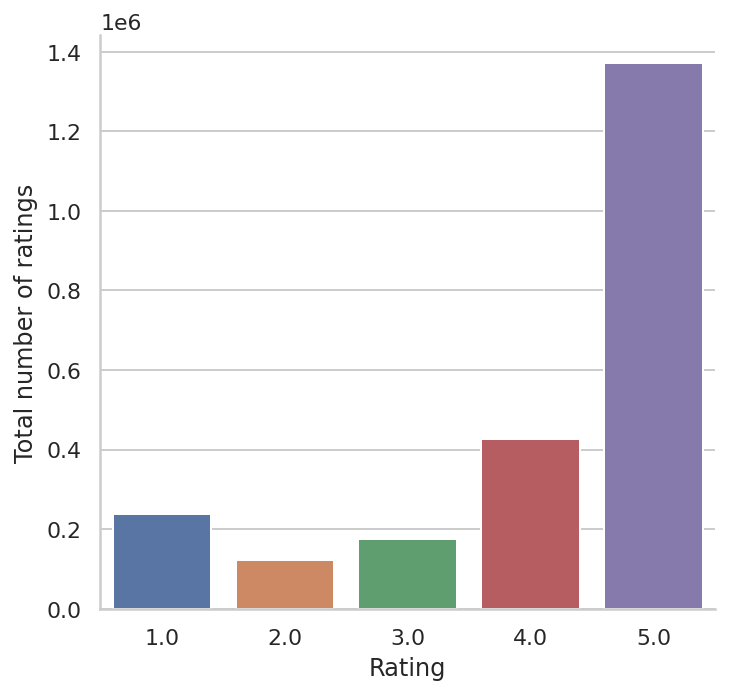

In [23]:
sns.set(font_scale=1)
with sns.axes_style('whitegrid'):
    g = sns.catplot("rating", data=testing_df, aspect=1.0,kind='count')
    g.set_ylabels("Total number of ratings")
    g.set_xlabels('Rating')

g.savefig('eda.png')

In [429]:
#sub-cateogry distributions
target_pcts = meta_df_extract.main_cat.value_counts(normalize=True) 

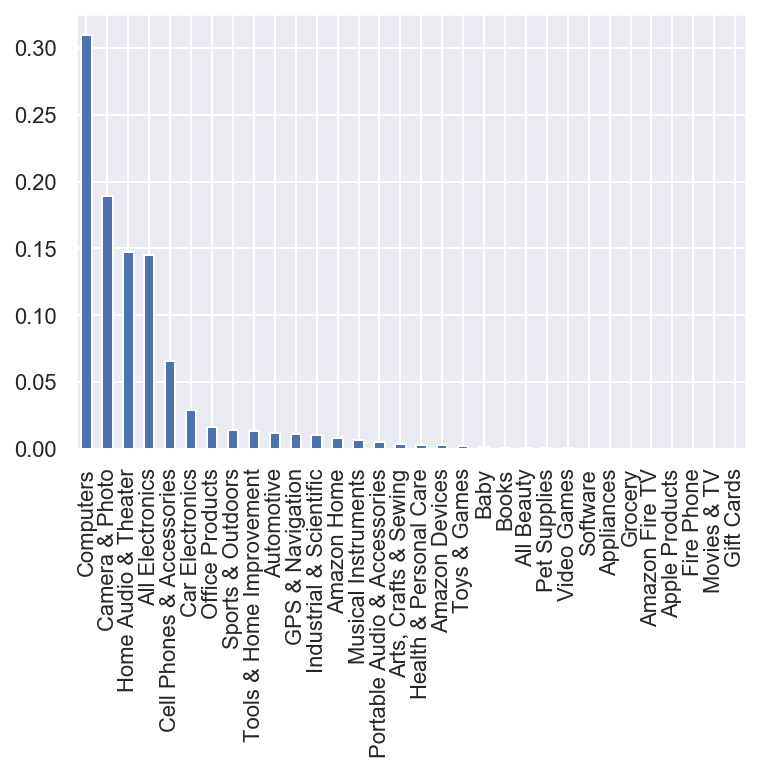

In [430]:
target_pcts.plot(kind='bar')

In [14]:
#Due to the class imbalance of the ratings. Everything below a 5 will be classified as a dislike

def like_dislike(df):
    
    df.loc[df['rating']==5,'y']=1
   
    df.loc[df['rating']!=5,'y']=0
like_dislike(ratings_df)

In [16]:
testing_df=ratings_df.merge(new_meta_df_extract,how='left',left_on='asin',right_on='asin')

In [ ]:
testing_df.to_pickle('testing_data.pkl')